In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 236.2 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 235.8 kB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.18.1-py3-none-any.whl size=139052 sha256=1e8748b67be472d7e18f027a8f07718306ca1eb1f54b59bf9e140bf57176bc4c
  Stored in directory: /Users/gianlucavisentin/Library/Caches/pip/wheels/91/08/75/7ec051c4c2b139cc4aa3a4ae6059d80900c301473b215aad59
Successfully built peewee
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [yfinance]4/5 [yfinance]


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define tickers (US, Europe, Japan)
tickers = ['IVV',      # iShares Core S&P 500 ETF (U.S.)
           'IEUR',     # iShares Core MSCI Europe ETF (Europe)
           'LCJP.AS']  # iShares MSCI Japan ESG UCITS ETF (Japan, Amsterdam listing)

# Step 2: Download historical data
raw_data = yf.download(tickers, start="2015-01-01", end="2025-06-30", auto_adjust=True)

# Step 3: Extract clean 'Close' prices and drop missing values
price_data = raw_data['Close'].copy()
price_data = price_data.dropna()

# Step 4: Check
print(price_data.head())

[*********************100%***********************]  3 of 3 completed

Ticker           IEUR         IVV      LCJP.AS
Date                                          
2018-02-28  39.414616  241.010757  1500.000000
2018-03-01  38.948120  237.801208  1476.137451
2018-03-02  39.011372  239.123886  1448.354492
2018-03-05  39.264385  241.768997  1437.603027
2018-03-06  39.549030  242.430313  1455.262817


In [2]:
# Step 5: Compute log daily returns
returns = np.log(price_data / price_data.shift(1)).dropna()

# Step 6: Compute mean daily returns and annualized mean returns
mean_daily_returns = returns.mean()
mean_annual_returns = mean_daily_returns * 252  # 252 trading days
print(mean_annual_returns)

Ticker
IEUR       0.073487
IVV        0.133714
LCJP.AS    0.093233
dtype: float64


In [3]:
# Step 7: Compute daily and annualized correlation matrix
cov_matrix_daily = returns.cov()
cov_matrix_annual = cov_matrix_daily * 252
print(returns.corr())

Ticker       IEUR       IVV   LCJP.AS
Ticker                               
IEUR     1.000000  0.832549  0.351883
IVV      0.832549  1.000000  0.314178
LCJP.AS  0.351883  0.314178  1.000000


In [4]:
# Step 8: Simulate random portfolios
mean_returns = returns.mean().to_numpy() * 252
num_portfolios = 10000
risk_free_rate = 0.03

results = []
weights_record = []

for _ in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)  # normalize to 1
    weights_record.append(weights)

    # Expected portfolio return
    port_return = np.sum(weights * mean_returns)

    # Expected portfolio volatility
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

    # Sharpe Ratio
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility

    results.append([port_volatility, port_return, sharpe_ratio])

results_array = np.array(results)

<Figure size 640x480 with 0 Axes>

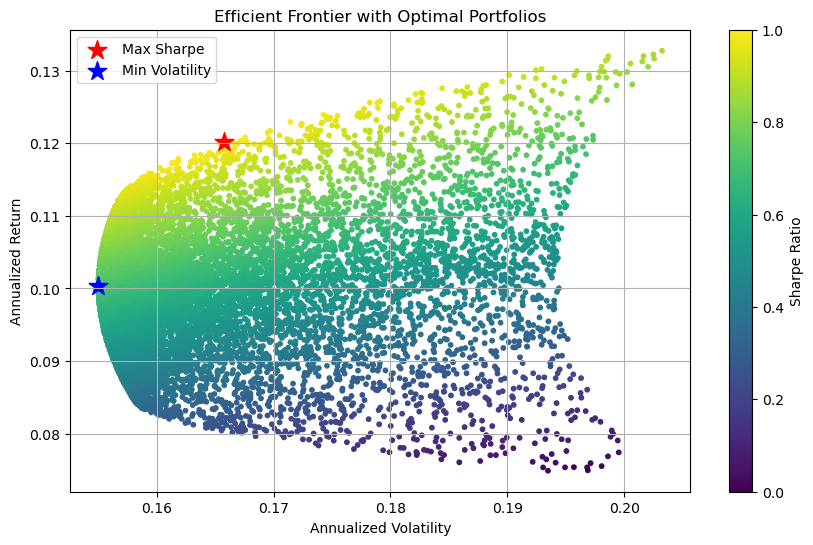

In [5]:
# Step 9: Visualize efficient frontier and optimal portfolios

# Extract results
volatilities = results_array[:, 0]
returns = results_array[:, 1]
sharpes = results_array[:, 2]

# Find max Sharpe and min volatility portfolio
max_sharpe_idx = np.argmax(sharpes)
min_vol_idx = np.argmin(volatilities)

# Convert weight records to array
weights_array = np.array(weights_record)

# Fixed color scale
vmin = min(sharpes)
vmax = max(sharpes)

# Plot
plt.clf()
plt.figure(figsize=(10, 6))
plt.scatter(volatilities, returns, c=sharpes, cmap='viridis', s=10, vmin=vmin, vmax=vmax)
plt.scatter(volatilities[max_sharpe_idx], returns[max_sharpe_idx], color='red', marker='*', s=200, label='Max Sharpe')
plt.scatter(volatilities[min_vol_idx], returns[min_vol_idx], color='blue', marker='*', s=200, label='Min Volatility')
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Efficient Frontier with Optimal Portfolios")
plt.colorbar(label="Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Step 10: Display optimal portfolio weights and stats

tickers = list(price_data.columns)

# Max Sharpe Portfolio
print("🔴 Max Sharpe Portfolio:")
for t, w in zip(tickers, weights_array[max_sharpe_idx]):
    print(f"{t}: {w:.2%}")
print(f"\nExpected Return: {returns[max_sharpe_idx]:.2%}")
print(f"Volatility      : {volatilities[max_sharpe_idx]:.2%}")
print(f"Sharpe Ratio    : {sharpes[max_sharpe_idx]:.2f}")

# Min Volatility Portfolio
print("\n🔵 Min Volatility Portfolio:")
for t, w in zip(tickers, weights_array[min_vol_idx]):
    print(f"{t}: {w:.2%}")
print(f"\nExpected Return: {returns[min_vol_idx]:.2%}")
print(f"Volatility      : {volatilities[min_vol_idx]:.2%}")
print(f"Sharpe Ratio    : {sharpes[min_vol_idx]:.2f}")


🔴 Max Sharpe Portfolio:
IEUR: 0.03%
IVV: 66.66%
LCJP.AS: 33.32%

Expected Return: 12.02%
Volatility      : 16.58%
Sharpe Ratio    : 0.54

🔵 Min Volatility Portfolio:
IEUR: 18.90%
IVV: 26.89%
LCJP.AS: 54.21%

Expected Return: 10.04%
Volatility      : 15.50%
Sharpe Ratio    : 0.45
